YouTube per-CPU CGroup residency analysis (with eas 1.3)
=======================
This is a run of the eas 1.3 branch from common on a wahoo device, with the following patches:
```
-rw-r----- 1 joelaf eng 11772 Jul 21 12:24 0001-sched-fair-streamline-find_best_target-heuristics.patch
-rw-r----- 1 joelaf eng  2962 Jul 21 12:24 0002-events-add-tracepoint-for-find_best_target.patch
-rw-r----- 1 joelaf eng  3307 Jul 21 12:24 0003-sched-fair-Update-signals-of-nohz-cpus-if-we-are-goi.patch
-rw-r----- 1 joelaf eng  1441 Jul 21 12:24 0004-sched-fair-kick-nohz-idle-balance-for-misfit-task.patch
-rw-r----- 1 joelaf eng  1424 Jul 21 12:24 0005-Revert-sched-fair-ensure-utilization-signals-are-syn.patch
-rw-r----- 1 joelaf eng  1478 Jul 21 12:24 0006-sched-fair-Sync-task-util-before-EAS-wakeup.patch
-rw-r----- 1 joelaf eng  3889 Jul 21 12:24 0007-sched-fair-Try-to-estimate-possible-idle-states.patch
-rw-r----- 1 joelaf eng  3563 Jul 21 12:24 0008-sched-fair-Add-a-backup_cpu-to-find_best_target.patch
```


In [1]:
#!/usr/bin/env python
%pylab inline
import trappy
from trace import Trace
import logging
import pandas as pd
import numpy as np
import os

from conf import LisaLogging
LisaLogging.setup(level=logging.ERROR)
logging.info('#### Setup FTrace')/home/joelaf/repo/lisa-aosp/external/lisa/results/YouTube_eas13_prefidle2_4.4.56-g931b784e1a3f-29958-gbabcada7d03d/trace.html
path_to_html = "/home/joelaf/repo/lisa-aosp/external/lisa/results/YouTube_eas13_4.4.56-g931b784e1a3f-29955-gb23d9461001d/trace.html"

Populating the interactive namespace from numpy and matplotlib


In [2]:
tr = Trace(None, path_to_html,
           cgroup_info = { 
               'cgroups': ['foreground', 'background', 'system-background', 'top-app', 'rt'],
               'controller_ids': { 4: 'cpuset', 2: 'schedtune' }
           },
           events=[ 'sched_switch', 'cgroup_attach_task_devlib', 'cgroup_attach_task', 'sched_process_fork' ],
           normalize_time=False)

Total amount of time spent per Cgroup (schedtune)
===========================
(NaN is the idle task)

In [3]:
tr.data_frame.cpu_residencies_cgroup('schedtune')

,cpu_0,cpu_1,cpu_2,cpu_3,cpu_4,cpu_5,cpu_6,cpu_7,total
schedtune,,,,,,,,,
background,0.181796,0.093132,0.035834,0.035993,0.000000,0.000000,0.248871,0.033227,0.628853
foreground,3.275281,2.490945,1.072858,0.795708,0.404360,0.082993,2.103421,2.119096,12.344662
root,4.910663,3.239125,3.660462,3.066602,0.340190,0.194053,1.212455,0.674773,17.298323
top-app,0.466919,0.276584,0.207017,0.197729,3.851309,2.598262,1.045346,0.325736,8.968902
NaN,23.400707,26.026429,27.149291,28.024113,27.513192,29.255163,27.575197,28.972064,217.916156


Plot per-CPU breakdown without considering idle time
------------------------------------------------------------

/home/joelaf/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


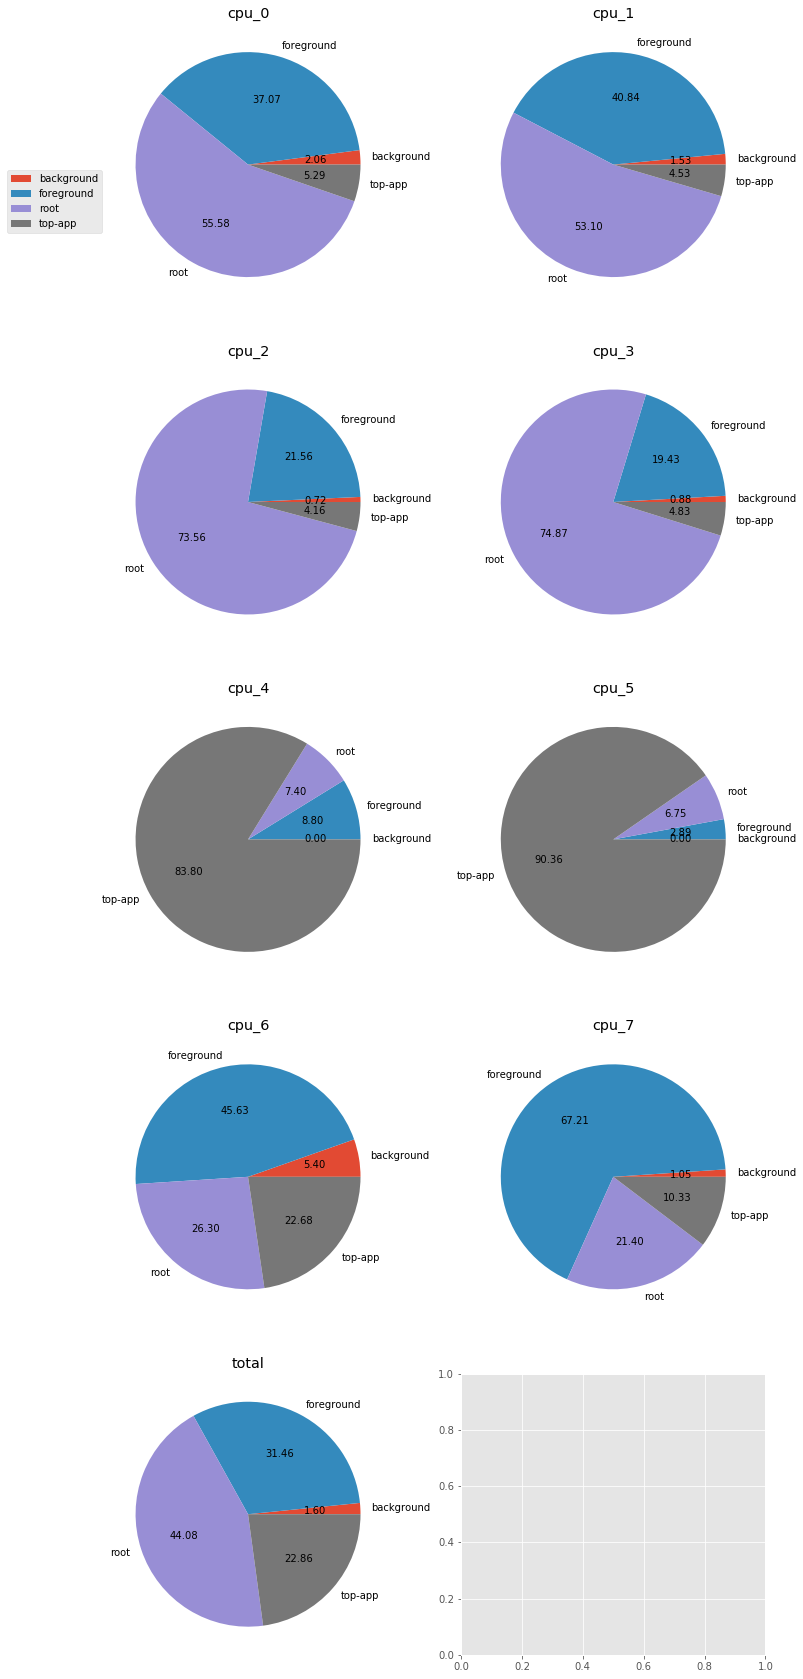

In [4]:
tr.analysis.residency.plot_cgroup('schedtune', idle=False)

Plot per-CPU breakdown WITH considering idle time (yellow slice)
------------------------------------------------------------

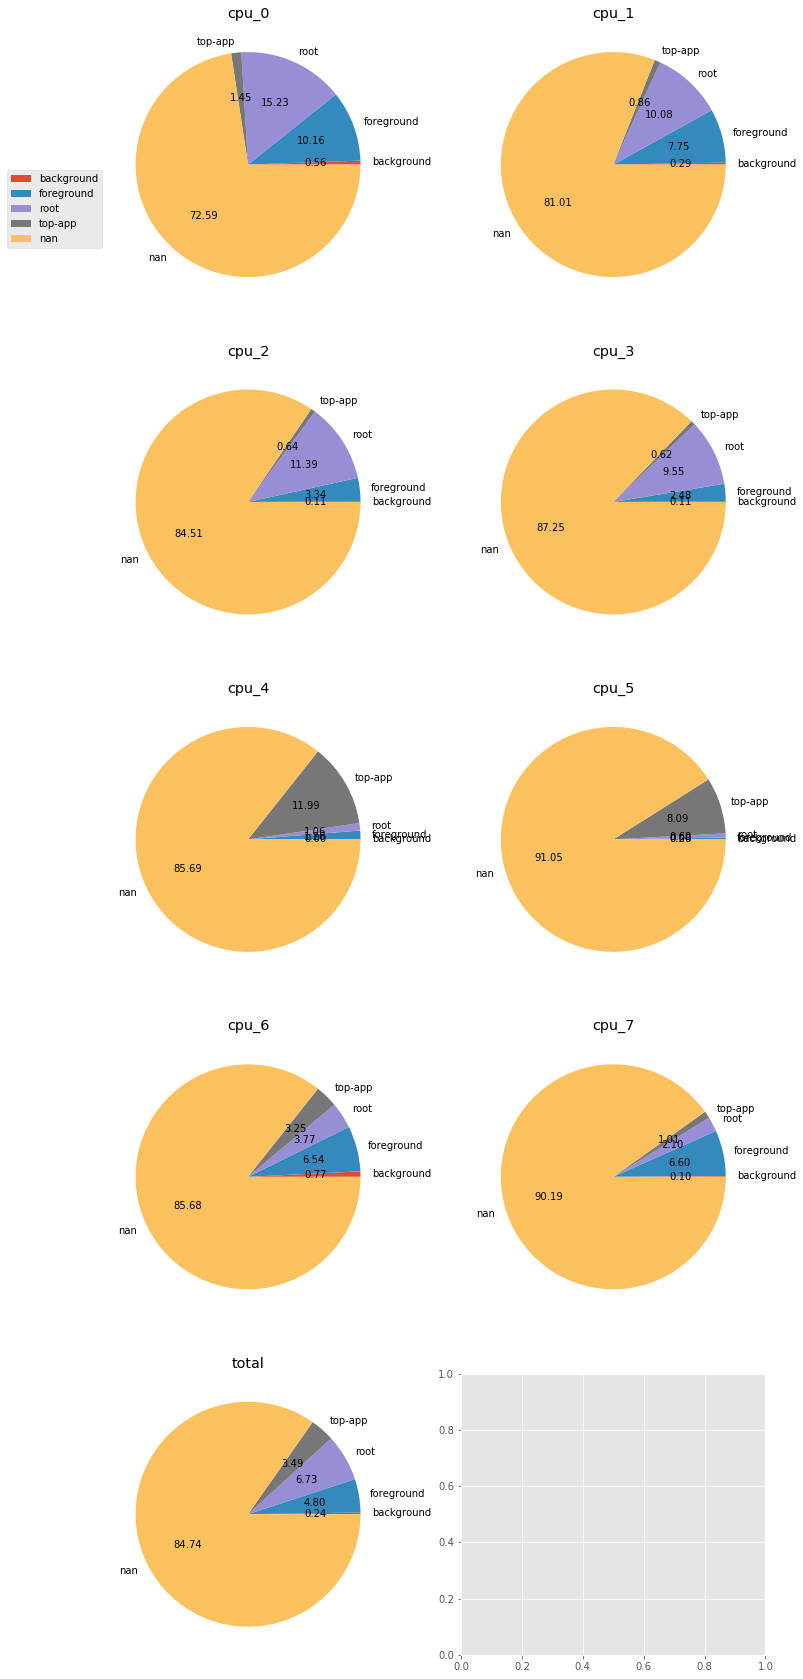

In [5]:
tr.analysis.residency.plot_cgroup('schedtune', idle=True)

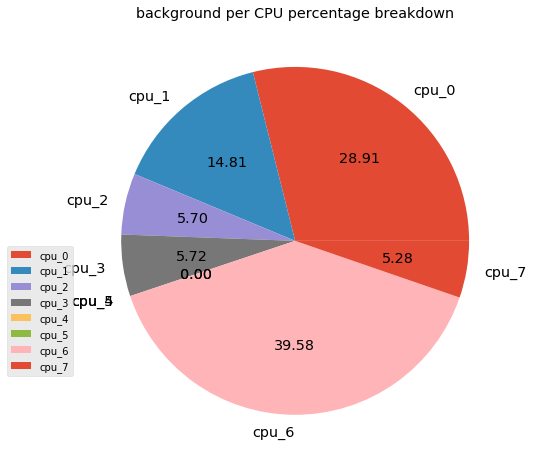

In [6]:
tr.analysis.residency.plot_cgroup('schedtune', cgroup='background')

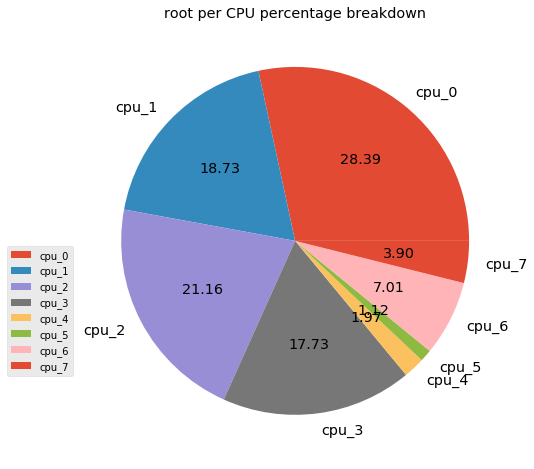

In [7]:
tr.analysis.residency.plot_cgroup('schedtune', cgroup='root')

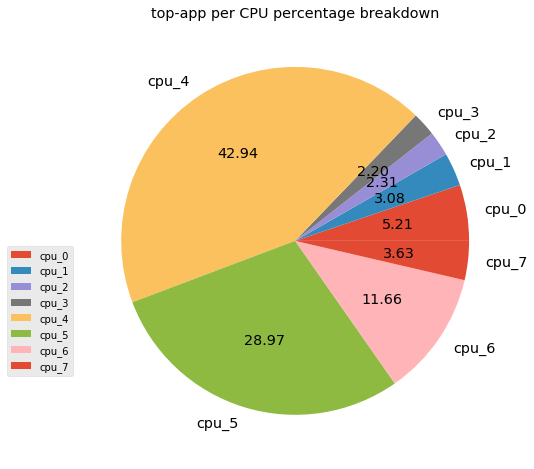

In [8]:
tr.analysis.residency.plot_cgroup('schedtune', cgroup='top-app')

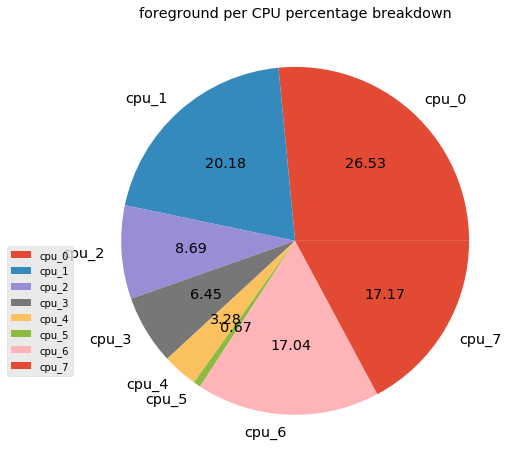

In [9]:
tr.analysis.residency.plot_cgroup('schedtune', cgroup='foreground')

Conclusions
-------------
* root CGroup ran considerably less on core 6 (7.5% to 2.6%) and slightly less on core 7 so there's definitely improvement with tasks that are not assigned to any CGroup with this patch stack
* Background group still runs on the big cores